https://num.pyro.ai/en/latest/examples/ode.html

In [1]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset,dset
from numpyro.infer import MCMC, NUTS, Predictive

matplotlib.use("Agg")  # noqa: E402


def dz_dt(z, t, theta):
    """
    Lotka–Volterra equations. Real positive parameters `alpha`, `beta`, `gamma`, `delta`
    describes the interaction of two species.
    """
    u = z[0]
    v = z[1]
    alpha, beta, gamma, delta = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
    )
    du_dt = (alpha - beta * v) * u
    dv_dt = (-gamma + delta * u) * v
    return jnp.stack([du_dt, dv_dt])


def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    # measurement times
    ts = jnp.arange(float(N))
    # parameters alpha, beta, gamma, delta of dz_dt
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 0.05, 1.0, 0.05]),
            scale=jnp.array([0.5, 0.05, 0.5, 0.05]),
        ),
    )
    # integrate dz/dt, the result will have shape N x 2
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    # measurement errors
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    # measured populations
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)




In [2]:
lines=open("LynxHare.txt").readlines()
data=np.array([ [float(_) for _ in line.split()] for line in lines])
data

array([[1.8450e+03, 1.9580e+01, 3.0090e+01],
       [1.8460e+03, 1.9600e+01, 4.5150e+01],
       [1.8470e+03, 1.9610e+01, 4.9150e+01],
       [1.8480e+03, 1.1990e+01, 3.9520e+01],
       [1.8490e+03, 2.8040e+01, 2.1230e+01],
       [1.8500e+03, 5.8000e+01, 8.4200e+00],
       [1.8510e+03, 7.4600e+01, 5.5600e+00],
       [1.8520e+03, 7.5090e+01, 5.0800e+00],
       [1.8530e+03, 8.8480e+01, 1.0170e+01],
       [1.8540e+03, 6.1280e+01, 1.9600e+01],
       [1.8550e+03, 7.4670e+01, 3.2910e+01],
       [1.8560e+03, 8.8060e+01, 3.4380e+01],
       [1.8570e+03, 6.8510e+01, 2.9590e+01],
       [1.8580e+03, 3.2190e+01, 2.1300e+01],
       [1.8590e+03, 1.2640e+01, 1.3690e+01],
       [1.8600e+03, 2.1490e+01, 7.6500e+00],
       [1.8610e+03, 3.0350e+01, 4.0800e+00],
       [1.8620e+03, 2.1800e+00, 4.0900e+00],
       [1.8630e+03, 1.5265e+02, 1.4330e+01],
       [1.8640e+03, 1.4836e+02, 3.8220e+01],
       [1.8650e+03, 8.5810e+01, 6.0780e+01],
       [1.8660e+03, 4.1410e+01, 7.0770e+01],
       [1.

In [3]:
data[:,0]

array([1845., 1846., 1847., 1848., 1849., 1850., 1851., 1852., 1853.,
       1854., 1855., 1856., 1857., 1858., 1859., 1860., 1861., 1862.,
       1863., 1864., 1865., 1866., 1867., 1868., 1869., 1870., 1871.,
       1872., 1873., 1874., 1875., 1876., 1877., 1878., 1879., 1880.,
       1881., 1882., 1883., 1884., 1885., 1886., 1887., 1888., 1889.,
       1890., 1891., 1892., 1893., 1894., 1895., 1896., 1897., 1898.,
       1899., 1900., 1901., 1902., 1903., 1904., 1905., 1906., 1907.,
       1908., 1909., 1910., 1911., 1912., 1913., 1914., 1915., 1916.,
       1917., 1918., 1919., 1920., 1921., 1922., 1923., 1924., 1925.,
       1926., 1927., 1928., 1929., 1930., 1931., 1932., 1933., 1934.,
       1935.])

In [4]:
year=data[:, 0].astype(int)
data=data[:, 1:]

In [5]:

# use dense_mass for better mixing rate
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_warmup=50,
    num_samples=200,
    num_chains=3,
    progress_bar=True
)
mcmc.run(PRNGKey(1), N=data.shape[0], y=data)
mcmc.print_summary()



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.82      0.29      0.98      0.42      1.10      1.55      5.37
  sigma[1]      0.47      0.08      0.50      0.37      0.56      1.71      2.74
  theta[0]      0.75      0.37      0.56      0.39      1.26      1.56      5.11
  theta[1]      1.40      1.96      0.02      0.02      4.17      1.50    611.99
  theta[2]      1.24      0.43      1.06      0.77      1.81      1.66      3.11
  theta[3]      0.34      0.43      0.04      0.02      0.95      1.50     71.23
 z_init[0]     36.23     23.83     45.84      4.24     61.87      1.62      3.47
 z_init[1]     23.69     16.20     30.29      1.89     41.05      1.62      3.55

Number of divergences: 0


In [9]:
%matplotlib inline

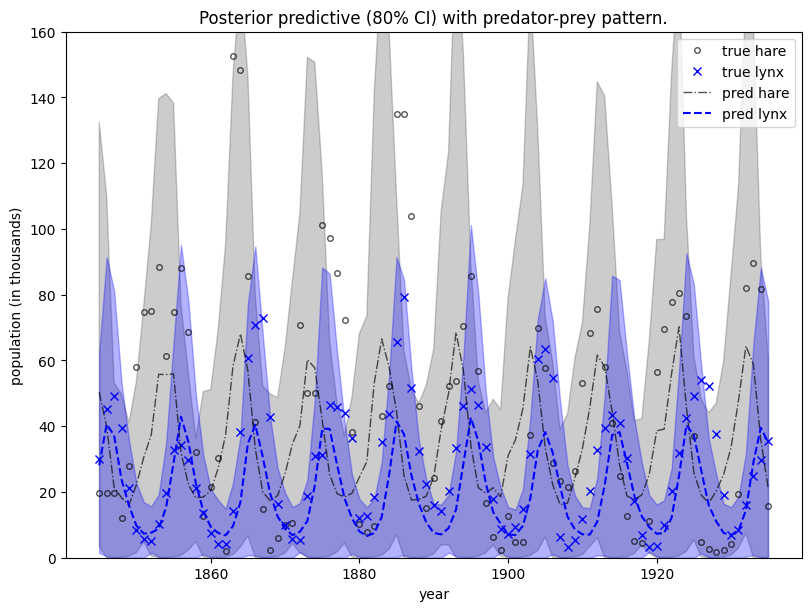

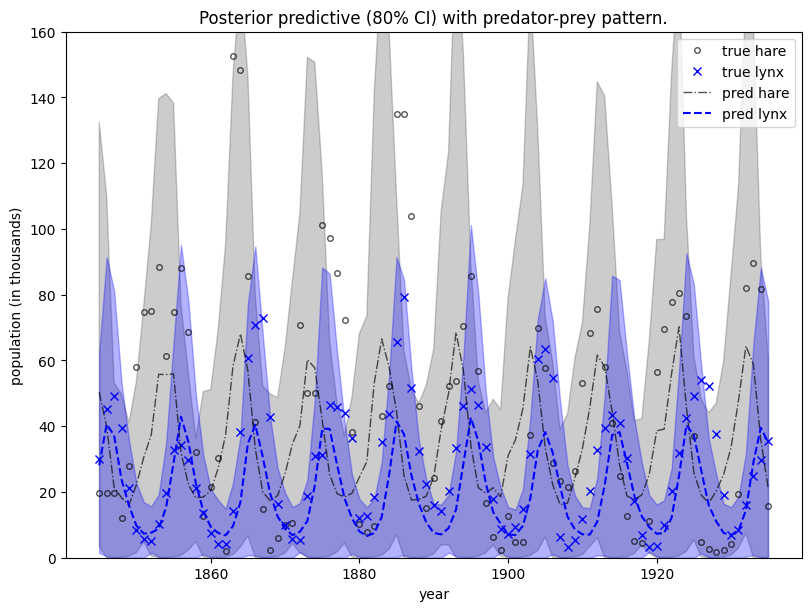

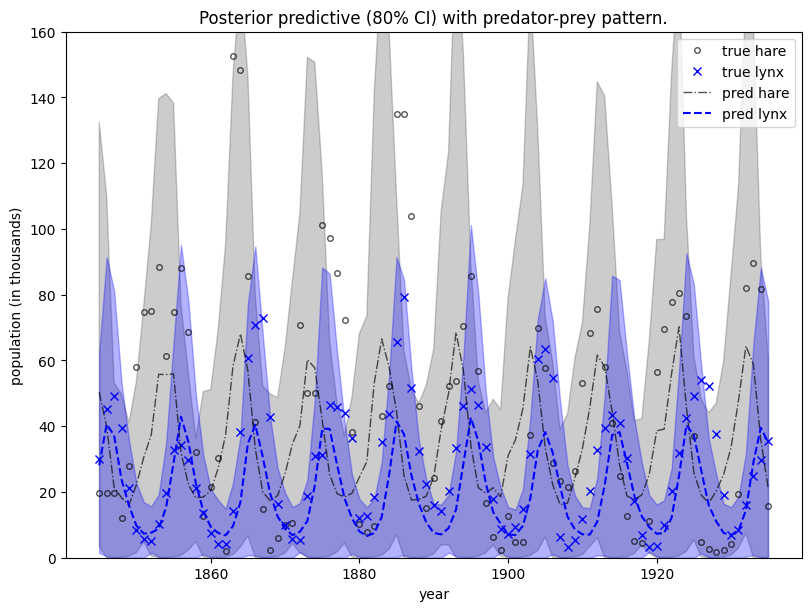

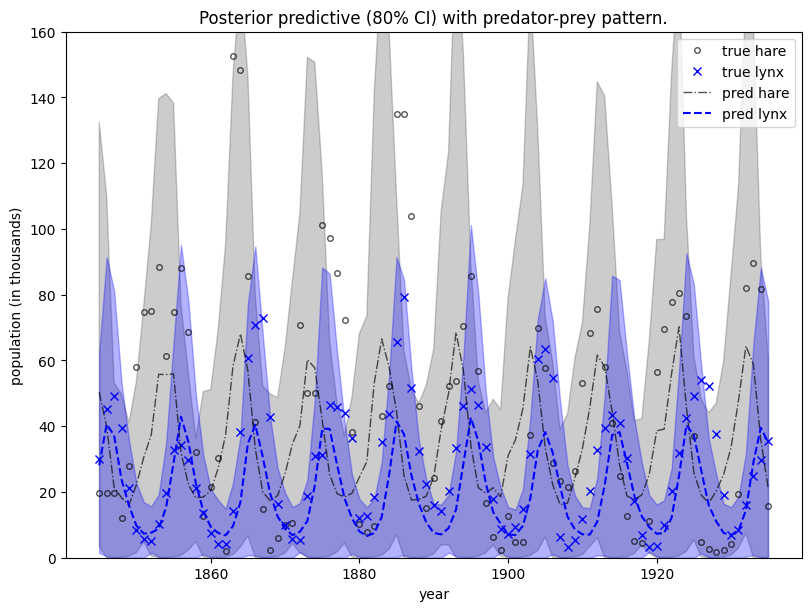

In [10]:

# predict populations
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
mu = jnp.mean(pop_pred, 0)
pi = jnp.percentile(pop_pred, jnp.array([10, 90]), 0)
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(year, data[:, 0], "ko", mfc="none", ms=4, label="true hare", alpha=0.67)
plt.plot(year, data[:, 1], "bx", label="true lynx")
plt.plot(year, mu[:, 0], "k-.", label="pred hare", lw=1, alpha=0.67)
plt.plot(year, mu[:, 1], "b--", label="pred lynx")
plt.fill_between(year, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(year, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.gca().set(ylim=(0, 160), xlabel="year", ylabel="population (in thousands)")
plt.title("Posterior predictive (80% CI) with predator-prey pattern.")
plt.legend()

plt.show()